In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/Dataset/merged_data_small.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [3]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [4]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [5]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [6]:
numerical_cols = ['rating', 'latitude', 'longitude', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

In [35]:
from sklearn.ensemble import IsolationForest
import numpy as np

important_features_scaled = ['num_feature_0', 'num_feature_3', 'num_feature_4']  # scaled rating, avg_rating, and num_of_reviews

final_df_optimized = pd.concat([num_df[important_features_scaled], text_df, resp_df], axis=1)

iso_forest_optimized = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest_optimized.fit_predict(final_df_optimized)

df['anomaly'] = np.where(df['anomaly_score'] == -1, "Suspicious", "Normal")


In [11]:
df[['name_y', 'rating', 'avg_rating', 'num_of_reviews', 'anomaly']].head(20)


,name_y,rating,avg_rating,num_of_reviews,anomaly
0,Five Guys,5.0,4.3,842.0,Normal
1,Price Rite of Seekonk,3.0,4.3,895.0,Normal
2,Coreanos Allston,4.0,4.6,446.0,Normal
3,Pied Bar,4.0,3.9,38.0,Normal
4,Chick-fil-A,4.0,4.5,2543.0,Normal
5,Naismith Memorial Basketball Hall of Fame,4.0,4.4,2426.0,Normal
6,Capri Pizza,4.0,4.5,508.0,Normal
7,Hall Memorial Pool,1.0,4.3,68.0,Normal
8,Mann Orchards,5.0,4.6,768.0,Normal
9,McDonald's,2.0,3.6,357.0,Normal


In [32]:
suspicious_businesses = df[df['anomaly'] == "Suspicious"]
suspicious_businesses.head(3)


,user_id,name_x,time,rating,text,resp,gmap_id,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,relative_results,url,anomaly_score,anomaly
10,108516292984194833708,Kelly Moniz,1584363629874,4.0,Excellent service,"{'time': 1584546750598, 'text': 'Thank you for...",0x89e4e4a771a2b5a1:0xaa0a81cc4243f4c4,99 Restaurants,"99 Restaurants, 161 Faunce Corner Rd, North Da...",41.652719,-70.986844,"['Restaurant', 'Bar', 'Bar & grill', 'New Engl...",4.3,926.0,"[['Tuesday', '11AM–9:30PM'], ['Wednesday', '11...","{'Service options': ['Curbside pickup', 'Deliv...","['0x89e4fcb3a3480ad7:0xba5a90641f3a907f', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
28,110778088802047490447,Cat D,1565296494452,5.0,Great place and the staff is awesome!!!,"{'time': 1565369782931, 'text': ""Hi there! Tha...",0x89e314af2e05250b:0x3f1464664138d7c2,Palm Beach Tan,"Palm Beach Tan, 1016 Paradise Rd, Swampscott, ...",42.484879,-70.900912,['Tanning salon'],4.0,17.0,"[['Tuesday', '11AM–8PM'], ['Wednesday', '11AM–...","{'Amenities': ['Gender-neutral restroom'], 'Pa...","['0x89e314a8ab1187a3:0x17ab58fa11d682cc', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious
42,112402711741657491733,Ritch Sternbach,1533768748481,4.0,This place is a great no pressure Dealership t...,"{'time': 1533909497052, 'text': ""Ritch, we str...",0x89e47fd0b70d5181:0xb8bf0242f46c5ea3,Clay Subaru,"Clay Subaru, 842 Providence Hwy Rte 1, Norwood...",42.183200,-71.186667,"['Subaru dealer', 'Auto broker', 'Auto repair ...",4.2,458.0,"[['Tuesday', '9AM–8PM'], ['Wednesday', '9AM–8P...","{'Service options': ['In-store shopping'], 'Ac...","['0x89e36317f466637b:0x218e94e29cd5f864', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious


In [13]:
print(df['anomaly'].value_counts())


anomaly
Normal        818417
Suspicious     43075
Name: count, dtype: int64


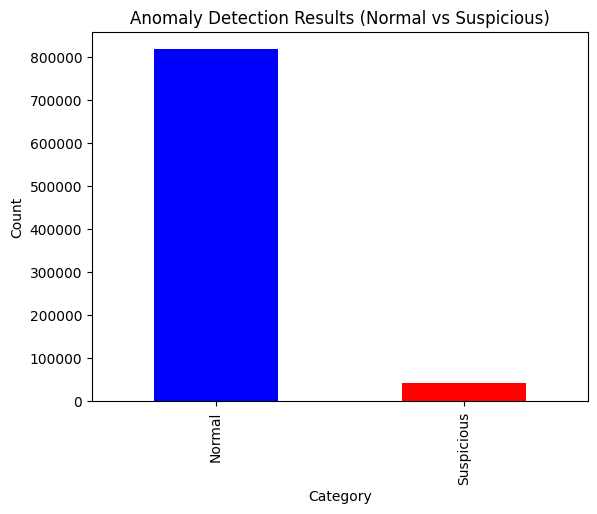

In [14]:
import matplotlib.pyplot as plt

df['anomaly'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Anomaly Detection Results (Normal vs Suspicious)")
plt.show()


Chart with full dataset.

In [15]:
#30% of data
df_sample = df.sample(frac=0.3, random_state=42)

text_df_reduced = text_df.iloc[:, :20]
resp_df_reduced = resp_df.iloc[:, :20]

final_df_optimized = pd.concat([num_df.loc[df_sample.index, important_features_scaled],
                                text_df_reduced.loc[df_sample.index],
                                resp_df_reduced.loc[df_sample.index]], axis=1)

iso_forest_optimized = IsolationForest(
    n_estimators=100,
    contamination=0.03,
    max_samples=5000,
    random_state=42,
    verbose=1
)
df_sample['anomaly_score'] = iso_forest_optimized.fit_predict(final_df_optimized)
df_sample['anomaly'] = np.where(df_sample['anomaly_score'] == -1, "Suspicious", "Normal")




[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


I did manual tuning before with whole dataset and my colab crashed, so I took a sample of the dataset here.

In [30]:
df_sample[['name_y', 'rating', 'avg_rating', 'num_of_reviews', 'anomaly']].head(20)


,name_y,rating,avg_rating,num_of_reviews,anomaly
76173,Arax Market,5.0,4.5,488.0,Normal
186462,Arturo's Ristorante,5.0,4.5,812.0,Normal
386586,Michaels,5.0,4.4,778.0,Normal
292577,The Spirit Shoppe,4.0,4.2,38.0,Normal
346640,Tint Works,5.0,4.8,148.0,Normal
699243,Domino's Pizza,5.0,4.0,107.0,Normal
254573,H&M,4.0,4.2,835.0,Normal
360022,Starbucks,3.0,4.1,158.0,Normal
732615,Market Basket,1.0,4.5,598.0,Normal
570070,Tavern in the Square,5.0,4.2,1438.0,Normal


In [31]:
suspicious_businesses = df_sample[df_sample['anomaly'] == "Suspicious"]
suspicious_businesses.head(3)


,user_id,name_x,time,rating,text,resp,gmap_id,name_y,address,latitude,...,category,avg_rating,num_of_reviews,hours,MISC,relative_results,url,anomaly_score,anomaly,num_feature_0
788995,106735362825975862464,Julia Zechello,1542842238720,5.0,Lola and Zach were the absolute best! Cannot w...,"{'time': 1542986669675, 'text': ""Thank you for...",0x8842448b81c9f937:0x59ddac578c16502b,Breakout Games - Boston (Marlborough),"Breakout Games - Boston (Marlborough), 21 Apex...",42.338197,...,['Escape room center'],4.9,2137.0,"[['Sunday', '10AM–11:30PM'], ['Monday', '10AM–...",{'Accessibility': ['Wheelchair accessible entr...,"['0x89e40667948f37a7:0xaecf73eb02095a97', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious,0.607172
29500,113758310803575954371,Matt Guillemette,1578274257837,5.0,Salesmen knew when to let me roam the floor an...,"{'time': 1578336165057, 'text': 'Hi Matt! We a...",0x89e6e0cf8be4ac87:0x839ad6d19e932c5b,Raymour & Flanigan Furniture and Mattress Outlet,Raymour & Flanigan Furniture and Mattress Outl...,42.122642,...,"['Furniture store', 'Bedroom furniture store',...",4.6,728.0,"[['Sunday', '11AM–6PM'], ['Monday', '10AM–9PM'...","{'Service options': ['Delivery', 'In-store pic...","['0x89e6e6c49299469b:0x7ba48fd6ea67f1e4', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious,0.607172
437830,106999754264130128141,Laurie M,1570734035592,5.0,N/A,"{'time': 1571084085245, 'text': ""Laurie, we're...",0x89e6c2ac05f28a49:0x96616024102f5c2d,Thrifty Car Sales - Springfield,"Thrifty Car Sales - Springfield, 880 Boston Rd...",42.137854,...,['Used car dealer'],4.3,224.0,"[['Thursday', '9AM–8PM'], ['Friday', '9AM–6PM'...","{'Service options': ['In-store shopping'], 'Ac...","['0x89e6e7ee71de013b:0xe0010d4db9e21d86', '0x8...",https://www.google.com/maps/place//data=!4m2!3...,-1,Suspicious,0.607172


In [18]:
df_sample['anomaly'].value_counts()


,count
anomaly,
Normal,250694
Suspicious,7754


In [19]:
feature_importance = pd.DataFrame({
    'Feature': final_df_optimized.columns,
    'Importance': iso_forest_optimized.decision_function(final_df_optimized).var(axis=0)
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


            Feature  Importance
0     num_feature_0    0.000962
32  resp_experience    0.000962
24        resp_best    0.000962
25    resp_business    0.000962
26         resp_com    0.000962
27        resp_come    0.000962
28     resp_contact    0.000962
29    resp_customer    0.000962
30   resp_customers    0.000962
31     resp_enjoyed    0.000962


In [25]:
df_analysis = df_sample[['name_y', 'anomaly']].merge(final_df_optimized, left_index=True, right_index=True)

df_analysis[df_analysis['anomaly'] == "Suspicious"][['name_y', 'anomaly'] + list(feature_importance['Feature'].head(10))]


,name_y,anomaly,num_feature_0,resp_experience,resp_best,resp_business,resp_com,resp_come,resp_contact,resp_customer,resp_customers,resp_enjoyed
788995,Breakout Games - Boston (Marlborough),Suspicious,0.607172,0.344794,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.441619
29500,Raymour & Flanigan Furniture and Mattress Outlet,Suspicious,0.607172,0.321704,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
437830,Thrifty Car Sales - Springfield,Suspicious,0.607172,0.000000,0.000000,0.000000,0.000000,0.0,0.571269,0.0,0.000000,0.000000
394735,Lawless CDJR,Suspicious,0.607172,0.355660,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
560784,Bourne's Auto Center,Suspicious,0.607172,0.000000,0.000000,0.342698,0.000000,0.0,0.375802,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
253109,Kings Dining & Entertainment,Suspicious,-2.016535,0.000000,0.000000,0.369924,0.362734,0.0,0.000000,0.0,0.000000,0.000000
379874,Monro Auto Service And Tire Centers,Suspicious,0.607172,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
527953,99 Restaurants,Suspicious,0.607172,0.228825,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
107822,Stop & Shop,Suspicious,0.607172,0.235696,0.296817,0.000000,0.000000,0.0,0.000000,0.0,0.315812,0.000000


Shows how much the features took part to see how it turned into Suspicious

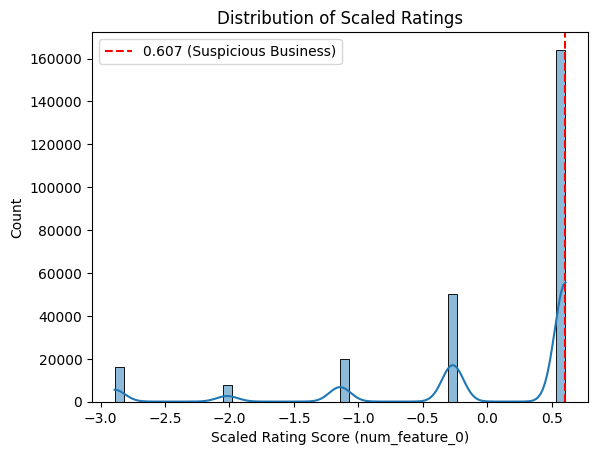

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


df_sample = df_sample.merge(num_df[['num_feature_0']], left_index=True, right_index=True)

sns.histplot(df_sample['num_feature_0'], bins=50, kde=True)
plt.axvline(0.607, color='red', linestyle='dashed', label="0.607 (Suspicious Business)")
plt.xlabel("Scaled Rating Score (num_feature_0)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Scaled Ratings")
plt.show()

This histogram shows the distribution of scaled ratings (num_feature_0) across all businesses in your dataset.

In [29]:
df_sample.groupby('anomaly')['num_feature_0'].describe()


,count,mean,std,min,25%,50%,75%,max
anomaly,,,,,,,,
Normal,250694.0,0.015280,0.980336,-2.891104,-0.267397,0.607172,0.607172,0.607172
Suspicious,7754.0,-0.387631,1.411447,-2.891104,-1.141966,0.607172,0.607172,0.607172
